<a href="https://colab.research.google.com/github/meyresearch/ANI-Peptides/blob/main/demos/AMBER_equilibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runtime Environment Setup

Before you start, ensure you have been allocated a GPU runtime. Go to `Runtime -> Change runtime type -> GPU`

Allow kernel to restart after running this cell.

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

Ensure good conda/mamba installation

In [2]:
# import condacolab
# condacolab.check()

Install Dependencies



*   *OpenMM* - Molecular dynamics simulation
*   *NGLView, PyTraj* - Viewing libraries



Test OpenMM

In [3]:
!python -m openmm.testInstallation


OpenMM Version: 7.6
Git Revision: ad113a0cb37991a2de67a08026cf3b91616bafbe

There are 3 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.31912e-06
Reference vs. OpenCL: 6.74163e-06
CPU vs. OpenCL: 7.27503e-07

All differences are within tolerance.


Fetch sample peptide

In [4]:
# !wget -q https://github.com/meyresearch/ANI-Peptides/raw/main/demos/aaa.pdb

# AMBER Simulation

In [16]:
# Import libraries

from openmm.app import *
from openmm import *
from openmm.unit import *
import time
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [6]:
# Progress bar for simulations

from IPython.display import ProgressBar

class ProgressBarWriter(ProgressBar):
    def write(self, string):
        if string.startswith("#"):
            self.progress = 0
        else:
            string = string.strip(',\n')
            try:
                self.progress = int(string)
            except ValueError:
                pass

def ProgressBarReporter(steps, interval):
    return StateDataReporter(
        ProgressBarWriter(total = steps), 
        interval, 
        step = True,
        totalSteps = steps,
    )

In [14]:
# Equilibration function - Constant pressure & temp

def equilibrate(
    coords: Topology,
    forcefield: ForceField,
    final_pressure: Quantity = 1*atmosphere,
    temp_range: range = range(0, 300, 25),
    output_state_data_filename = "equilibration_state_data.csv",
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 4*femtoseconds,
    time_per_temp_increment: Quantity = 0.005*nanoseconds,
    time_final_stage: Quantity = 0.05*nanoseconds,
):
    print("Initialising equilibration run...")
    # adjust the range to include the highest temp (stop value)
    inclusive_temp_range = range(
        temp_range.start,
        temp_range.stop + temp_range.step,
        temp_range.step
    )
    temperatures = Quantity(inclusive_temp_range, kelvin)
    steps_per_temp_increment = int(time_per_temp_increment / step_size)
    steps_final_stage = int(time_final_stage / step_size)

    # Create system
    system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )
    # Create constant temp integrator
    integrator = LangevinIntegrator(
        temperatures.min(),
        friction_coeff,
        step_size
    )
    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        system,
        integrator
    )
    simulation.context.setPositions(coords.positions)
    # simulation.reporters.append(
    #     PlotReporter(range(
    #         0, 
    #         steps_per_temp_increment + steps_per_temp_increment//10, 
    #         steps_per_temp_increment//10)
    #     )
    # )
    state_reporter = StateDataReporter(
        output_state_data_filename,
        steps_per_temp_increment//10,
        temperature = True,
        potentialEnergy = True,
    )
    simulation.reporters.append(state_reporter)

    # Local energy minimisation
    print("Local energy minimisation...")
    simulation.minimizeEnergy()
    # Heating to final temp
    print(f"Equilibrating {temperatures.min()} to {temperatures.max()} in {len(temperatures)} stages, {time_per_temp_increment} per stage")
    progress_bar = ProgressBar(len(temperatures))
    progress_bar.progress = 0
    for stage, temperature in enumerate(temperatures):
        print(f"Heating stage {stage+1}/{len(temperatures)} at {temperature}")
        integrator.setTemperature(temperature)
        simulation.step(steps_per_temp_increment)
        progress_bar.progress += 1
    # Final equilibration, constant pressure 
    print(f"Final equilibration at {final_pressure} for {time_final_stage}")
    barostat = MonteCarloBarostat(
        final_pressure,
        temperatures.max()
    )
    system.addForce(barostat)
    simulation.step(steps_final_stage)
    print("Done")
    return simulation

In [49]:
# Load sample peptide
pdb = PDBFile('ypgdv.pdb')

# Create AMBER forcefield
forcefield = ForceField(
    'amber14-all.xml',
    'amber14/tip3p.xml'
)

# Load pdb into modeller and add solvent
modeller = Modeller(pdb.topology, pdb.positions)

modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer, neutralize=False)

simulation = equilibrate(
    modeller,
    forcefield,
    temp_range = range(0, 300, 20),
    time_per_temp_increment = 0.001 * nanoseconds,
    time_final_stage = 0.05 * nanoseconds
)

ValueError: No template found for residue 5 (VAL).  The set of atoms is similar to NGLN, but it is missing 1 atoms.

In [20]:
report = pd.read_csv('equilibration_state_data.csv')
report.head()

,"#""Potential Energy (kJ/mole)""",Temperature (K)
0,-49462.269265,0.001331
1,-49462.675515,0.000906
2,-49462.941140,0.000780
3,-49463.081765,0.000717
4,-49463.363015,0.000679


In [21]:
report = report.melt()
report.head()

,variable,value
0,"#""Potential Energy (kJ/mole)""",-49462.269265
1,"#""Potential Energy (kJ/mole)""",-49462.675515
2,"#""Potential Energy (kJ/mole)""",-49462.941140
3,"#""Potential Energy (kJ/mole)""",-49463.081765
4,"#""Potential Energy (kJ/mole)""",-49463.363015


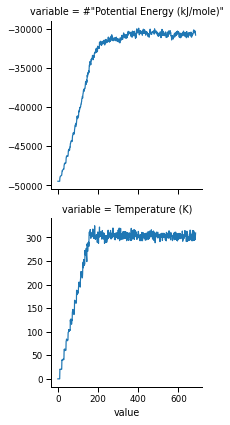

In [30]:
with sns.plotting_context('paper'): 
    g = sns.FacetGrid(data=report, row='variable', sharey=False )
    g.map(plt.plot, 'value')
    plt.savefig('equilibration.pdf', bbox_inches='tight')

In [11]:
# Equilibration graph viewer

import matplotlib.pyplot as plt
import csv

with open('equilibration_state_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    
    headers = next(plots)
    reports_per_stage = int(next(plots)[1])
    print(reports_per_stage)
    data = list(zip(*plots))
    data[0] = tuple(map(int, data[0]))
    
    plt.figure()
    
    for header_idx in range(1, len(headers)):
        plt.subplot(len(headers)-1, 1, header_idx)
        plt.xlabel(headers[0])
        plt.ylabel(headers[header_idx])
        plt.plot(data[0], [float(i) for i in data[header_idx]])

10


ValueError: invalid literal for int() with base 10: '#Stage 1'

### Ignore beyond this point

In [ ]:
# Live graph reporter of temp and potential energy
# only works in jupyter notebooks :/
import matplotlib.pyplot as plt

class PlotWriter:
    plt.ion()
    titles, data = None, None
    def __init__(self, x_steps):
        self.x_steps = x_steps

    def setup(self, string):
        self.step_iterator = iter(self.x_steps)
        self.x_vals = []
        self.titles = string.strip("#").replace('"', '').split(",")
        self.data = tuple([] for i in range(len(self.titles)))
        self.lines = []
        self.figure, self.axs = plt.subplots(len(self.titles), 1, sharex=True)
        for idx, ax in enumerate(self.axs):
            line, = ax.plot([],[], 'o')
            self.lines.append(line)
            #Autoscale on unknown axis and known lims on the other
            ax.set_autoscaley_on(True)
            ax.set_xlim(self.x_steps.start, self.x_steps.stop)
            ax.grid()
            ax.set_xlabel("Heating Stage Coordinate")
            ax.set_ylabel(self.titles[idx])
        self.figure

    def write(self, string):
        string = string.strip()
        if string.startswith("#"):
            self.setup(string)
        elif self.data and self.titles and string:
            self.x_vals.append(next(self.step_iterator))
            for idx, val in enumerate(string.split(",")):
                print(val)
                self.data[idx].append(float(val))
                #Update data (with the new _and_ the old points)
                self.lines[idx].set_xdata(self.x_vals)
                self.lines[idx].set_ydata(self.data[idx])
                #Need both of these in order to rescale
                self.axs[idx].relim()
                self.axs[idx].autoscale_view()
            #We need to draw *and* flush
            self.figure.canvas.draw()
            self.figure.canvas.flush_events()

def PlotReporter(x_steps):
    return StateDataReporter(
        PlotWriter(x_steps),
        x_steps.step,
        temperature = True,
        potentialEnergy = True,
    )

In [ ]:
# Simulation function (to run simulations consistently)

def simulate(
    simulation,
    output_pdb_filename: str = "output.pdb",
    output_state_data_filename: str = "state_data.csv",
    step_size: Quantity = 0.004*femtoseconds,
    steps: int or None = 100000,
    duration: Quantity or None = None,
    pdb_report_interval: int or None = None,
    state_report_interval: int or None = None,
    progressbar_interval: int or None = None,
):
    assert duration or steps

    if duration:
        steps = int(duration / step_size)

    if not pdb_report_interval:
        pdb_report_interval = steps // 10

    if not state_report_interval:
        state_report_interval = steps // 10

    if not progressbar_interval:
        progressbar_interval = steps // 50

    # Create pdb file reporter
    simulation.reporters.append(
        PDBReporter(
            output_pdb_filename,
            pdb_report_interval
        )
    )

    # Create state data file reporter
    simulation.reporters.append(
        StateDataReporter(
            output_state_data_filename, 
            state_report_interval, 
            step=True,
            potentialEnergy=True, 
            temperature=True
        )
    )

    # Create progress bar reporter
    simulation.reporters.append(
        ProgressBarReporter(steps, progressbar_interval)
    )

    # Run simulation through specified time steps
    print("Running simulation...")
    simulation.step(steps)

In [ ]:
# Production function - Constant volume & temp

def production(
    coords: Topology,
    forcefield: ForceField,
    temperature: Quantity = 300*kelvin,
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 0.004*femtoseconds,
    **kwargs
):      
    print("Initialising production run...")

    # Create system
    system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )

    # Create constant temp integrator
    integrator = LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        step_size
    )

    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        system,
        integrator
    )
    simulation.context.setPositions(coords.positions)

    simulate(
        simulation,
        **kwargs
    )

    return simulation

In [ ]:
# Load sample peptide
pdb = PDBFile('aaa.pdb')

# Create AMBER forcefield
forcefield = ForceField(
    'amber14-all.xml',
    'amber14/tip3pfb.xml'
)

# Load pdb into modeller and add solvent
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)

simulation = equilibrate(
    modeller,
    forcefield,
    pressure = 1*atmosphere,
    temperature = 300*kelvin,
    friction_coeff = 1/femtosecond,
    step_size = 0.004*femtoseconds,
    steps = 10000,
    output_pdb_filename = "equilibration_output.pdb",
    output_state_data_filename = "equilibration_state_data.csv"
)

simulation.positions = simulation.context.getState(getPositions=True).getPositions()

production(
    simulation,
    forcefield,
    temperature = 300*kelvin,
    friction_coeff = 1/femtosecond,
    step_size = 0.004*femtoseconds,
    steps = 10000,
    output_pdb_filename = "production_output.pdb",
    output_state_data_filename = "production_state_data.csv"
)

# Viewer

In [ ]:
import pytraj as pt
import nglview as nv
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
traj = pt.load("production_output.pdb")
view = nv.show_pytraj(traj)
view.add_representation("licorice")
view.add_unitcell()
view